In [123]:
import openaq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from aqtools import aqutils as u

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

from noaa_sdk import noaa

api = openaq.OpenAQ()

In [124]:
date_from = '2021-09-01T00:00:00Z'
date_to = '2022-03-01T00:00:00Z'

In [125]:
# co

status, resp = api.measurements(city='San Francisco-Oakland-Fremont',
                                location='Oakland', parameter='co',
                                date_from=date_from,
                                date_to=date_to,
                                limit=5000)
r = resp['results']
df_co = pd.DataFrame(data=r)
df_co['date'] = u.extract_localdate(df_co['date'].values)
df_co = df_co.rename(columns={"value": "co"})
df_co = df_co.loc[:, ['date', 'co']]
df_co = df_co.iloc[::-1]
df_co = df_co[df_co['co'] >= 0]

df_co.head(3)

,date,co
3600,2021-08-31 17:00:00,0.3
3599,2021-08-31 18:00:00,0.3
3598,2021-08-31 19:00:00,0.3


In [8]:
# no2
status, resp = api.measurements(city='San Francisco-Oakland-Fremont',
                                location='Oakland', parameter='no2',
                                date_from=date_from,
                                date_to=date_to,
                                limit=5000)
r = resp['results']
df_no2 = pd.DataFrame(data=r)
df_no2['date'] = u.extract_localdate(df_no2['date'].values)
df_no2 = df_no2.rename(columns={"value": "no2"})
df_no2 = df_no2.loc[:, ['date', 'no2']]
df_no2 = df_no2.iloc[::-1]
df_no2 = df_no2[df_no2['no2'] >= 0]

df_no2.head(3)

,date,no2
4495,2021-09-09 17:00:00,0.004
4494,2021-09-09 18:00:00,0.003
4493,2021-09-09 19:00:00,0.006


In [ ]:
# o3
status, resp = api.measurements(city='San Francisco-Oakland-Fremont',
                                location='Oakland', parameter='o3',
                                date_from=date_from,
                                date_to=date_to,
                                limit=100)
r = resp['results']
df_o3 = pd.DataFrame(data=r)
# df_o3['date'] = u.extract_localdate(df_o3['date'].values)
# df_o3 = df_o3.rename(columns={"value": "o3"})
# df_o3 = df_o3.loc[:, ['date', 'o3']]
# df_o3 = df_o3.iloc[::-1]
# df_o3 = df_o3[df_o3['o3'] >= 0]

df_o3.head(3)

,location,parameter,value,date,unit,coordinates,country,city
0,Oakland,o3,0.034,"{'utc': '2022-05-01T00:00:00Z', 'local': '2022...",ppm,"{'latitude': 37.743061, 'longitude': -122.169907}",US,San Francisco-Oakland-Fremont
1,Oakland,o3,0.032,"{'utc': '2022-04-30T23:00:00Z', 'local': '2022...",ppm,"{'latitude': 37.743061, 'longitude': -122.169907}",US,San Francisco-Oakland-Fremont
2,Oakland,o3,0.029,"{'utc': '2022-04-30T22:00:00Z', 'local': '2022...",ppm,"{'latitude': 37.743061, 'longitude': -122.169907}",US,San Francisco-Oakland-Fremont


In [10]:
# pm25
status, resp = api.measurements(city='San Francisco-Oakland-Fremont',
                                location='Oakland', parameter='pm25',
                                date_from=date_from,
                                date_to=date_to,
                                limit=5000)
r = resp['results']
df_pm25 = pd.DataFrame(data=r)
df_pm25['date'] = u.extract_localdate(df_pm25['date'].values)
df_pm25 = df_pm25.rename(columns={"value": "pm25"})
df_pm25 = df_pm25.loc[:, ['date', 'pm25']]
df_pm25 = df_pm25.iloc[::-1]
df_pm25 = df_pm25[df_pm25['pm25'] >= 0]

df_pm25.head(3)

,date,pm25
4610,2021-09-13 17:00:00,16
4609,2021-09-13 18:00:00,14
4608,2021-09-13 19:00:00,15


In [25]:
# pm25
status, resp = api.measurements(city='San Francisco-Oakland-Fremont',
                                location='Oakland', parameter='so2',
                                date_from=date_from,
                                date_to=date_to,
                                limit=100)

r = resp['results']
df_pm25 = pd.DataFrame(data=r)
# df_pm25['date'] = u.extract_localdate(df_pm25['date'].values)
# df_pm25 = df_pm25.rename(columns={"value": "pm25"})
# df_pm25 = df_pm25.loc[:, ['date', 'pm25']]
# df_pm25 = df_pm25.iloc[::-1]
# df_pm25 = df_pm25[df_pm25['pm25'] >= 0]

df_pm25.head(10)

,id,name,description,preferredUnit
0,1,pm10,Particulate matter less than 10 micrometers in...,µg/m³
1,2,pm25,Particulate matter less than 2.5 micrometers i...,µg/m³
2,3,o3,Ozone mass concentration,µg/m³
3,4,co,Carbon Monoxide mass concentration,µg/m³
4,5,no2,Nitrogen Dioxide mass concentration,µg/m³
5,6,so2,Sulfur Dioxide mass concentration,µg/m³
6,7,no2,Nitrogen Dioxide concentration,ppm
7,8,co,Carbon Monoxide concentration,ppm
8,9,so2,Sulfur Dioxide concentration,ppm
9,10,o3,Ozone concentration,ppm


In [16]:
# Merge dataframes on 'date' (find the intersection of values based on 'date')
df = df_co.merge(df_no2, how='inner', on='date')
df = df.merge(df_o3, how='inner', on='date')
df = df.merge(df_pm25, how='inner', on='date')
df = df.set_index(['date'])
df

,co,no2,o3,pm25
date,,,,
2021-09-14 17:00:00,0.37,0.004,0.027,16
2021-09-14 18:00:00,0.36,0.005,0.026,21
2021-09-14 19:00:00,0.35,0.003,0.027,13
2021-09-14 20:00:00,0.34,0.004,0.027,12
2021-09-14 21:00:00,0.36,0.005,0.027,9
...,...,...,...,...
2022-04-30 13:00:00,0.25,0.003,0.029,8
2022-04-30 14:00:00,0.25,0.002,0.029,4
2022-04-30 15:00:00,0.24,0.002,0.029,4


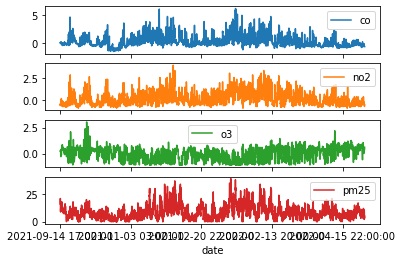

In [20]:
# MinMax Scaling
scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['co'].values.reshape(-1, 1))
df['co'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['no2'].values.reshape(-1, 1))
df['no2'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['o3'] = co_scaled

df.plot(subplots=True)
plt.show()

/tmp/ipykernel_2173/3282434271.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co'] = co_diff
/tmp/ipykernel_2173/3282434271.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no2'] = no2_diff
/tmp/ipykernel_2173/3282434271.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

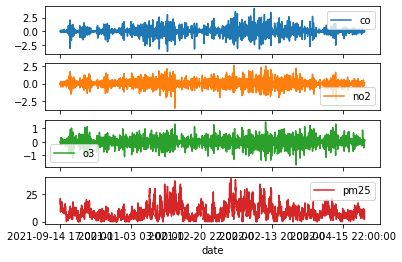

In [21]:
# Make data stationary
# Differencing technique was applied

co_diff = u.differencing(df['co'].values)
no2_diff = u.differencing(df['no2'].values)
o3_diff = u.differencing(df['o3'].values)
# Delete the first row
df = df.iloc[:-1, :]

df['co'] = co_diff
df['no2'] = no2_diff
df['o3'] = o3_diff
df.plot(subplots=True)
plt.show()

In [22]:
# feature vectors: shape (num of data, window size, num of features)
feature_np = df[['co', 'no2', 'o3']].to_numpy()

# label vactors: shape (num of data,)
label_np = df[['pm25']].to_numpy()
X = []
y = []

# how many timesteps we want to look at --> default 8 (hours)
for i in range(8, len(feature_np)):
    X.append(feature_np[i-8:i, :])
    y.append(label_np[i])

X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
X.shape, y.shape

((4305, 8, 3), (4305, 1))

In [15]:
# correlation among features
df.corr()

,co,no2,o3,pm25
co,1.000000,0.681116,-0.629678,-0.123555
no2,0.681116,1.000000,-0.772292,-0.120832
o3,-0.629678,-0.772292,1.000000,0.080260
pm25,-0.123555,-0.120832,0.080260,1.000000


In [ ]:
TEST_SIZE = 300

X_train = X[:-TEST_SIZE]
y_train = y[:-TEST_SIZE]
X_test = X[-TEST_SIZE:]
y_test = y[-TEST_SIZE:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# Predict pm2.5 using Gated Recurrent Unit

model = Sequential()
model.add(GRU(units=50,
              return_sequences=True,
              input_shape=(X_train[0].shape),
              activation='tanh'))
model.add(GRU(units=50, activation='tanh'))
model.add(Dense(units=2))

# Compiling the GRU
model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7,
                            momentum=0.9, nesterov=False),
              loss='mse')

model.summary()

In [ ]:
# model training
#early_stop = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10)
#model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=1, callbacks=[early_stop])

model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=1)

In [ ]:
pred = model.predict(X_test)
pred = [p.mean() for p in pred]
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='actual', color='blue')
plt.plot(pred, label='prediction', color='orange')
plt.xlabel('time step (hour)')
plt.ylabel('concentrations of pm 2.5 (ug/m^3)')
plt.grid()
plt.legend(loc='best')
plt.show()

In [131]:
start_time = '2022-05-02T00:00:00Z'
end_time = '2022-05-10T00:00:00Z'

start_time = u.pst_to_utc(start_time)
end_time = u.pst_to_utc(end_time)

AttributeError: module 'aqtools.aqutils' has no attribute 'pst_to_utc'

In [132]:
n = noaa.NOAA()
res = n.get_observations('94603', 'US', start=start_time, end=end_time, num_of_stations=1)
dates = []
windspeed=[]
relativehum=[]

for i in res:
    dates.append(u.utc_to_pst(i['timestamp']))
    windspeed.append(i['windSpeed']['value'])
    relativehum.append(i['relativeHumidity']['value'])
df_w = pd.DataFrame()
df_w['date'] = dates
df_w['wind speed'] = windspeed
df_w['relative humidity'] = relativehum
df_w['date'] = pd.to_datetime(df['date'])

# fill na with median
df_w[['wind speed', 'relative humidity']] = df_w[['wind speed', 'relative humidity']].fillna(df[['wind speed', 'relative humidity']].median())
df_w = df_w.sort_values(by="date")
# df.to_csv('./fillna weather.csv')
df_w

AttributeError: module 'aqtools.aqutils' has no attribute 'utc_to_pst'

'2022-05-06 14:53:00'